# Negative Binomial Regression

## Negative binomial distribution review

I always experience some kind of confusion when looking at the negative binomial distribution after a while of not working with it. There are so many different definitions that I usually need to read everything more than once. The definition I've first learned, and the one I like the most, says as follows: The negative binomial distribution is the distribution of a random variable that is defined as the number of independent Bernoulli trials until the k-th "success". In short, we repeat a Bernoulli experiment until we observe k  successes and record the number of trials it required.

$$
Y \sim \text{NB}(k, p)
$$

where $0 \le p \le 1$ is the probability of success in each Bernoulli trial, $k > 0$, usually integer, and $y \in \{k, k + 1, \cdots\}$

The probability mass function (pmf) is 

$$
p(y | k, p)= \binom{y - 1}{y-k}(1 -p)^{y - k}p^k
$$

If you, like me, find it hard to remember whether $y$ starts at $0$, $1$, or $k$, try to think twice about the definition of the variable. But how? First, recall we aim to have $k$ successes. And success is one of the two possible outcomes of a trial, so the number of trials can never be smaller than the number of successes. Thus, we can be confident to say that $y \ge k$.

But this is not the only way of defining the negative binomial distribution, there are plenty of options! One of the most interesting, and the one you see in [PyMC3](https://docs.pymc.io/api/distributions/discrete.html#pymc3.distributions.discrete.NegativeBinomial), the library we use in Bambi for the backend, is as a continuous mixture. The negative binomial distribution describes a Poisson random variable whose rate is also a random variable (not a fixed constant!) following a gamma distribution. Or in other words, conditional on a gamma-distributed variable $\mu$, the variable $Y$ has a Poisson distribution with mean $\mu$.

Under this alternative definition, the pmf is

$$
\displaystyle p(y | k, \alpha) = \binom{y + \alpha - 1}{y} \left(\frac{\alpha}{\mu + \alpha}\right)^\alpha\left(\frac{\mu}{\mu + \alpha}\right)^y
$$

where $\mu$ is the parameter of the Poisson distribution (the mean, and variance too!) and $\alpha$ is the rate parameter of the gamma.

In [1]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.stats import nbinom

In [2]:
az.style.use("arviz-darkgrid")

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In SciPy, the definition of the negative binomial distribution differs a little from the one in our introduction. They define $Y$ = Number of failures until k sucesses and then $y$ starts at 0. In the following plot, we have  the probability of observing $y$ failures before we see $k=3$ successes. 

In [4]:
y = np.arange(0, 30)
k = 3
p1 = 0.5
p2 = 0.3

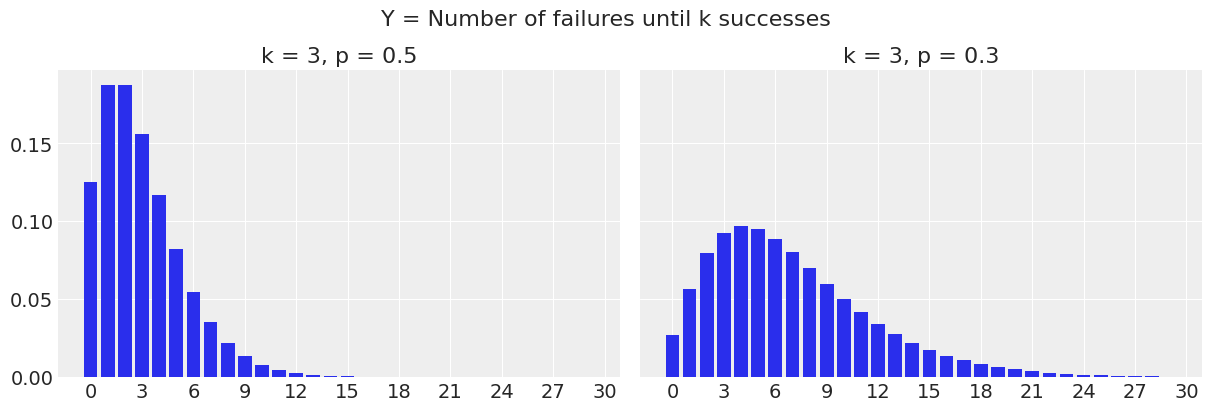

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

ax[0].bar(y, nbinom.pmf(y, k, p1))
ax[0].set_xticks(np.linspace(0, 30, num=11))
ax[0].set_title(f"k = {k}, p = {p1}")

ax[1].bar(y, nbinom.pmf(y, k, p2))
ax[1].set_xticks(np.linspace(0, 30, num=11))
ax[1].set_title(f"k = {k}, p = {p2}")

fig.suptitle("Y = Number of failures until k successes", fontsize=16);

For example, when $p=0.5$, the probability of seeing $y=0$ failures before 3 successes (or in other words, the probability of having 3 successes out of 3 trials) is 0.125, and the probability of seeing $y=3$ failures before 3 successes is 0.156.

In [6]:
print(nbinom.pmf(y, k, p1)[0])
print(nbinom.pmf(y, k, p1)[3])

0.12500000000000003
0.15625000000000003


Finally, if one wants to show this probability mass function as if we are following the first definition of negative binomial distribution we introduced, we just need to shift the whole thing to the right by adding $k$ to the $y$ values.

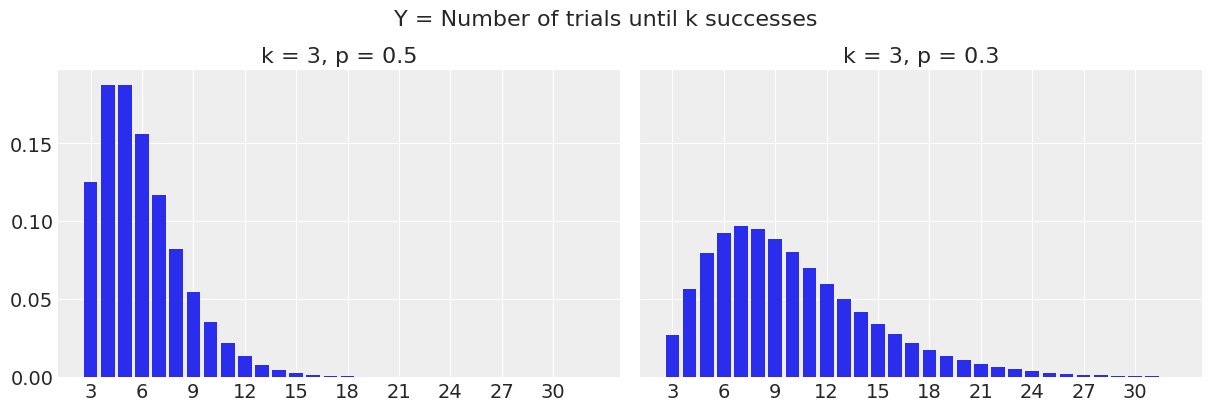

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

ax[0].bar(y + k, nbinom.pmf(y, k, p1))
ax[0].set_xticks(np.linspace(3, 30, num=10))
ax[0].set_title(f"k = {k}, p = {p1}")

ax[1].bar(y + k, nbinom.pmf(y, k, p2))
ax[1].set_xticks(np.linspace(3, 30, num=10))
ax[1].set_title(f"k = {k}, p = {p2}")

fig.suptitle("Y = Number of trials until k successes", fontsize=16);

## Negative binomial in GLM

The negative binomial distribution belongs to the exponential family, and the canonical link function is 

$$
g(\mu_i) = \log\left(\frac{\mu_i}{k + \mu_i}\right) = \log\left(\frac{k}{\mu_i} + 1\right)
$$

but it is difficult to interpret. The log link is usually preferred because of the analogy with Poisson model, and it also tends to give better results.

## Load and explore Students data

This example is based on this [UCLA example](https://stats.idre.ucla.edu/r/dae/negative-binomial-regression/).

School administrators study the attendance behavior of high school juniors at two schools.  Predictors of the **number of days of absence** include the **type of program** in which the student is enrolled and a **standardized test in math**. We have attendance data on 314 high school juniors.

The variables of insterest in the dataset are

* daysabs: The number of days of abscence. It is our response variable.
* progr: The type of program. Can be one of 'General', 'Academic', or 'Vocational'.
* math: Score in a standardized math test.

In [8]:
data = pd.read_stata("https://stats.idre.ucla.edu/stat/stata/dae/nb_data.dta")

In [9]:
data.head()

,id,gender,math,daysabs,prog
0,1001.0,male,63.0,4.0,2.0
1,1002.0,male,27.0,4.0,2.0
2,1003.0,female,20.0,2.0,2.0
3,1004.0,female,16.0,3.0,2.0
4,1005.0,female,2.0,3.0,2.0


We assign categories to the values 1, 2, and 3 of our `"prog"` variable.

In [10]:
data["prog"] = data["prog"].map({1: "General", 2: "Academic", 3: "Vocational"})
data.head()

,id,gender,math,daysabs,prog
0,1001.0,male,63.0,4.0,Academic
1,1002.0,male,27.0,4.0,Academic
2,1003.0,female,20.0,2.0,Academic
3,1004.0,female,16.0,3.0,Academic
4,1005.0,female,2.0,3.0,Academic


The Academic program is the most popular program (167/314) and General is the least popular one (40/314)

In [11]:
data["prog"].value_counts()

Academic      167
Vocational    107
General        40
Name: prog, dtype: int64

Let's explore the distributions of math score and days of absence for each of the three programs listed above. The vertical lines indicate the mean values.

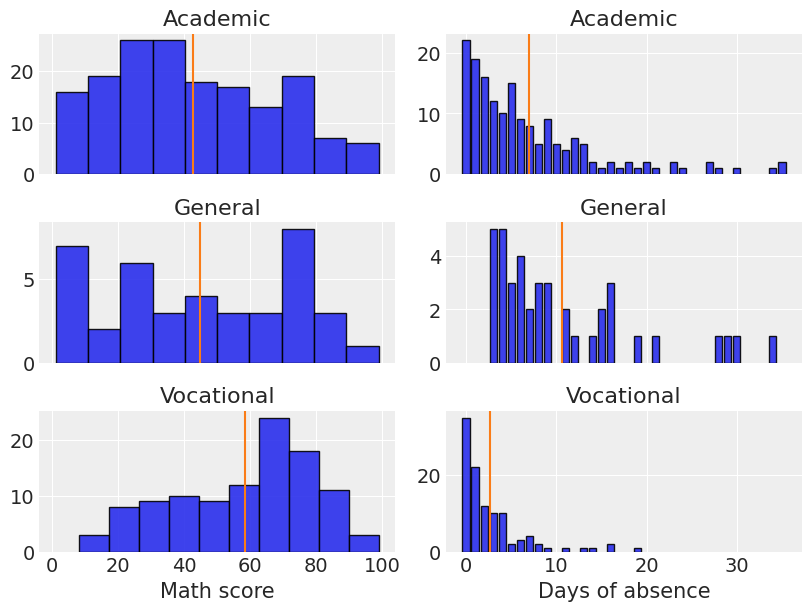

In [12]:
fig, ax = plt.subplots(3, 2, figsize=(8, 6), sharex="col")
programs = list(data["prog"].unique())
programs.sort()

for idx, program in enumerate(programs):
    # Histogram
    ax[idx, 0].hist(data[data["prog"] == program]["math"], edgecolor='black', alpha=0.9)
    ax[idx, 0].axvline(data[data["prog"] == program]["math"].mean(), color="C1")
    
    # Barplot
    days = data[data["prog"] == program]["daysabs"]
    days_mean = days.mean()
    days_counts = days.value_counts()
    values = list(days_counts._index)
    count = days_counts.values
    ax[idx, 1].bar(values, count, edgecolor='black', alpha=0.9)
    ax[idx, 1].axvline(days_mean, color="C1")
    
    # Titles
    ax[idx, 0].set_title(program)
    ax[idx, 1].set_title(program)

plt.setp(ax[-1, 0], xlabel="Math score")
plt.setp(ax[-1, 1], xlabel="Days of absence");

The first impression we have is that the distribution of math scores is not equal for any of the programs. It looks right-skewed for students under the Academic program, left-skewed for students under the Vocational program, and roughly uniform for students in the General program (although there's a drop in the highest values). Clearly those in the Vocational program has the highest mean for the math score.
 
On the other hand, the distribution of the days of absence is right-skewed in all cases. Students in the General program present the highest absence mean while the Vocational group is the one who misses fewer classes on average.

## Models

We are interested in measuring the association between the type of the program and the math score with the days of absence. It's also of interest to see if the association between math score and days of absence is different in each type of program. 

In order to answer our questions, we are going to fit and compare two models. The first model uses the type of the program and the math score as predictors. The second model also includes the interaction between these two variables. The score in the math test is going to be standardized in both cases to make things easier for the sampler and save some seconds. A good idea to follow along is to run these models without scaling `math` and comparing how long it took to fit.

By default, Bambi uses a log link for negative binomial GLMs. We'll stick to this default here.

### Model 1 

$$
\log{Y_i} = \beta_1 \text{Academic}_i + \beta_2 \text{General}_i + \beta_3 \text{Vocational}_i + \beta_4 \text{Math_std}_i
$$

### Model 2

$$
\log{Y_i} = \beta_1 \text{Academic}_i + \beta_2 \text{General}_i + \beta_3 \text{Vocational}_i + \beta_4 \text{Math_std}_i
            + \beta_5 \text{General}_i \cdot \text{Math_std}_i + \beta_6 \text{Vocational}_i \cdot \text{Math_std}_i
$$

In both cases we have the following dummy variables


$$\text{Academic}_i = 
\left\{ 
    \begin{array}{ll}
        1 & \textrm{if student is under Academic program} \\
        0 & \textrm{other case} 
    \end{array}
\right.
$$

$$\text{General}_i = 
\left\{ 
    \begin{array}{ll}
        1 & \textrm{if student is under General program} \\
        0 & \textrm{other case} 
    \end{array}
\right.
$$

$$\text{Vocational}_i = 
\left\{ 
    \begin{array}{ll}
        1 & \textrm{if student is under Vocational program} \\
        0 & \textrm{other case} 
    \end{array}
\right.
$$

and $Y$ represents the days of absence.

So, for example, the first model for a student under the Vocational program reduces to
$$
\log{Y_i} = \beta_3 + \beta_4 \text{Math_std}_i
$$

And one last thing to note is we've decided not to inclide an intercept term, that's why you don't see any $\beta_0$ above. This choice allows us to represent the effect of each program directly with $\beta_1$, $\beta_2$, and $\beta_3$.

## Model fit

It's very easy to fit these models with Bambi. We just pass a formula describing the terms in the model and Bambi will know how to handle each of them correctly. The `0` on the right hand side of `~` simply means we don't want to have the intercept term that is added by default. `scale(math)` tells Bambi we want to use standardize `math` before being included in the model.

### Model 1

In [13]:
model_additive = bmb.Model("daysabs ~ 0 + prog + scale(math)", data, family="negativebinomial")
idata_additive = model_additive.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [daysabs_alpha, scale(math), prog]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.


### Model 2

For this second model we just add `prog:scale(math)` to indicate the interaction. A shorthand would be to use `y ~ 0 + prog*scale(math)`, which uses the **full interaction** operator. In other words, it just means we want to include the interaction between `prog` and `scale(math)` as well as their main effects.

In [14]:
model_interaction = bmb.Model("daysabs ~ 0 + prog + scale(math) + prog:scale(math)", data, family="negativebinomial")
idata_interaction = model_interaction.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [daysabs_alpha, prog:scale(math), scale(math), prog]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.


## Explore models

The first thing we do is calling `az.summary()`. Here we pass the `InferenceData` object the `.fit()` returned. This prints information about the marginal posteriors for each parameter in the model as well as convergence diagnostics.

In [15]:
az.summary(idata_additive)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
prog[Academic],1.889,0.087,1.737,2.058,0.002,0.001,3087.0,1574.0,1.0
prog[General],2.323,0.170,2.019,2.647,0.003,0.002,3217.0,1440.0,1.0
prog[Vocational],1.057,0.114,0.864,1.279,0.002,0.001,3034.0,1563.0,1.0
scale(math),-0.152,0.065,-0.278,-0.033,0.001,0.001,2655.0,1667.0,1.0
daysabs_alpha,1.020,0.111,0.831,1.244,0.002,0.001,3041.0,1642.0,1.0


In [16]:
az.summary(idata_interaction)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
prog[Academic],1.883,0.084,1.722,2.036,0.002,0.001,1987.0,1531.0,1.0
prog[General],2.331,0.161,2.047,2.636,0.004,0.003,2114.0,1399.0,1.0
prog[Vocational],1.002,0.128,0.763,1.237,0.003,0.002,2094.0,1561.0,1.0
scale(math),-0.190,0.078,-0.329,-0.038,0.002,0.001,1875.0,1389.0,1.0
prog:scale(math)[General],0.008,0.167,-0.302,0.318,0.004,0.003,1934.0,1556.0,1.0
prog:scale(math)[Vocational],0.181,0.159,-0.109,0.493,0.004,0.003,1915.0,1598.0,1.0
daysabs_alpha,1.023,0.111,0.812,1.221,0.003,0.002,1984.0,1232.0,1.0


The information in the two tables above can be visualized in a more concise manner using a forest plot. ArviZ provides us with `plot_forest()`. There we simply pass a list containing the `InferenceData` objects of the models we want to compare.

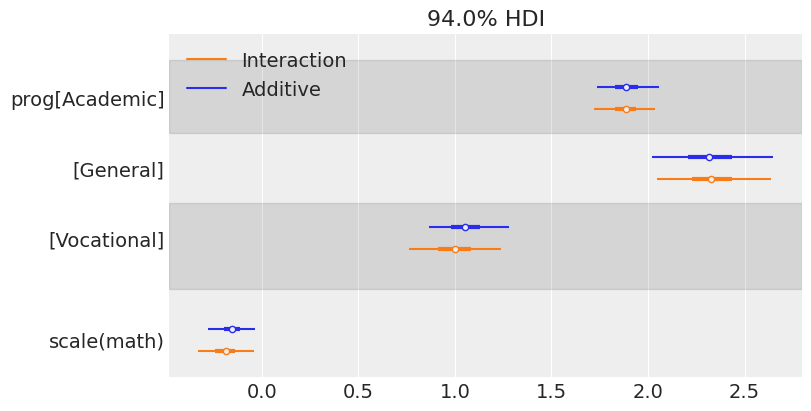

In [17]:
az.plot_forest(
    [idata_additive, idata_interaction],
    model_names=["Additive", "Interaction"],
    var_names=["prog", "scale(math)"],
    combined=True,
    figsize=(8, 4)
);

One of the first things one can note when seeing this plot is the similarity between the marginal posteriors. Maybe one can conclude that the variability of the marginal posterior of `scale(math)` is slightly lower in the model that considers the interaction, but the difference is not significant. 

We can also make conclusions about the association between the program and the math score with the days of absence. First, we see the posterior for the Vocational group is to the left of the posterior for the two other programs, meaning it is associated with fewer absences (as we have seen when first exploring our data). There also seems to be a difference between General and Academic, where we may conclude the students in the General group tend to miss more classes.

In addition, the marginal posterior for `math` shows negative values in both cases. This means that students with higher math scores tend to miss fewer classes. Below, we see a forest plot with the posteriors for the coefficients of the interaction effects. Both of them overlap with 0, which means the data does not give much evidence to support there is an interaction effect between program and math score (i.e., the association between math and days of absence is similar for all the programs).

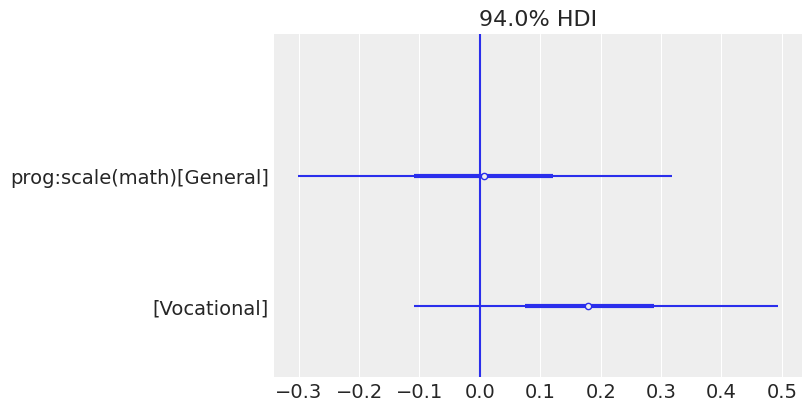

In [18]:
az.plot_forest(idata_interaction, var_names=["prog:scale(math)"], combined=True, figsize=(8, 4))
plt.axvline(0);

## Plot predicted mean response

We finish this example showing how we can get predictions for new data and plot the mean response for each program together with confidence intervals.

In [19]:
math_score = np.arange(1, 100)

# This function takes a model and an InferenceData object.
# It returns of length 3 with predictions for each type of program.
def predict(model, idata):
    posterior = idata.posterior.stack(sample=["chain", "draw"])
    β = np.vstack([np.atleast_2d(posterior[name]) for name in model.terms])
    
    predictions = []
    for program in programs:
        new_data = pd.DataFrame({"math": math_score, "prog": [program] * len(math_score)})
        X = model._design.common._evaluate_new_data(new_data).design_matrix
        predictions.append(np.exp(np.dot(X, β)))
    
    return predictions

In [20]:
prediction_additive = predict(model_additive, idata_additive)
prediction_interaction = predict(model_interaction, idata_interaction)

In [21]:
mu_additive = [prediction.mean(1) for prediction in prediction_additive]
mu_interaction = [prediction.mean(1) for prediction in prediction_interaction]

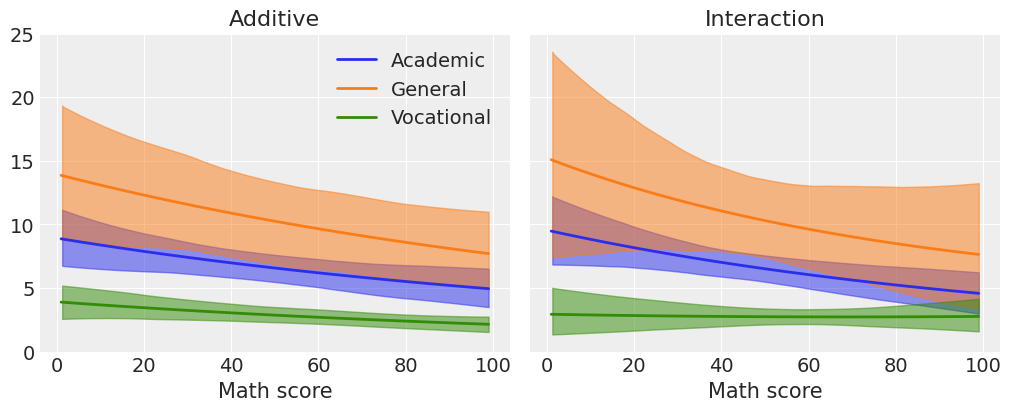

In [22]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize = (10, 4))

for idx, program in enumerate(programs):
    ax[0].plot(math_score, mu_additive[idx], label=f"{program}", color=f"C{idx}", lw=2)
    az.plot_hdi(math_score, prediction_additive[idx].T, color=f"C{idx}", ax=ax[0])

    ax[1].plot(math_score, mu_interaction[idx], label=f"{program}", color=f"C{idx}", lw=2)
    az.plot_hdi(math_score, prediction_interaction[idx].T, color=f"C{idx}", ax=ax[1])

ax[0].set_title("Additive");
ax[1].set_title("Interaction");
ax[0].set_xlabel("Math score")
ax[1].set_xlabel("Math score")
ax[0].set_ylim(0, 25)
ax[0].legend(loc="upper right");

As we can see in this plot, the interval for the mean response for the Vocational program does not overlap with the interval for the other two groups, representing the group of students who miss fewer classes. On the right panel we can also see that including interaction terms does not change the slopes significantly because the posterior distributions of these coefficients have a substantial overlap with 0.

If you've made it to the end of this notebook and you're still curious about what else you can do with these two models, you're invited to use `az.compare()` to compare the fit of the two models. What do you expect before seeing the plot? Why? Is there anything else you could do to improve the fit of the model?

In [23]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Thu May 20 2021

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.18.1

bambi     : 0.5.0
matplotlib: 3.3.3
arviz     : 0.11.2
pandas    : 1.2.2
numpy     : 1.20.1

Watermark: 2.1.0

